<a href="https://colab.research.google.com/github/kab1012/Speech-to-Text/blob/master/Speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing all the necessary libraries


In [0]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

# Mounting google drive in order to upload the dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Data Exploration and Visualisation

Visualization of Audio Signals in time-series domain

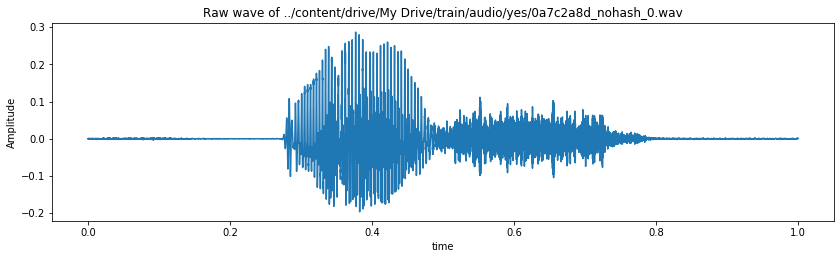

In [4]:
train_audio_path = '../content/drive/My Drive/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../content/drive/My Drive/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Sampling Rate (at 16000 Hz)

In [5]:
ipd.Audio(samples, rate=sample_rate)

In [6]:

print(sample_rate)

16000


Resampling (at 8000 Hz)

In [7]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

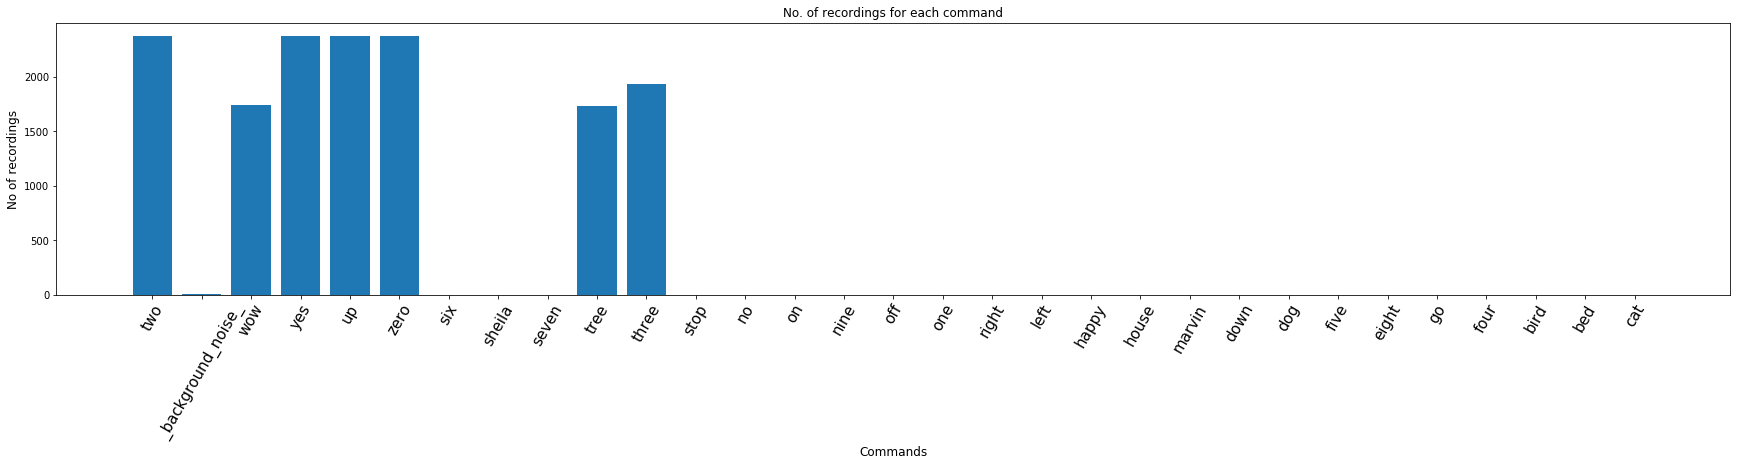

In [8]:

labels=os.listdir(train_audio_path)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
  waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
  no_of_recordings.append(len(waves))
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

Duration of Recording

(array([   9.,    5.,   13.,   17.,   60.,   47.,   92.,   65.,  128.,
        4316.]),
 array([0.469375 , 0.5224375, 0.5755   , 0.6285625, 0.681625 , 0.7346875,
        0.78775  , 0.8408125, 0.893875 , 0.9469375, 1.       ]),
 <a list of 10 Patch objects>)

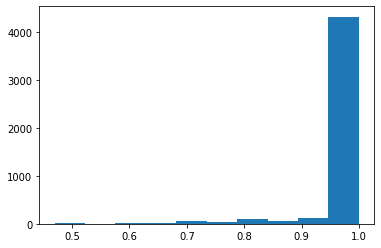

In [9]:
duration_of_recordings=[]
for label in labels:
  waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
  for wav in waves:
    sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
    duration_of_recordings.append(float(len(samples)/sample_rate))
  
plt.hist(np.array(duration_of_recordings))

Preprocessing the audio waves

In [10]:
train_audio_path = '../content/drive/My Drive/train/audio/'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
      samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
      samples = librosa.resample(samples, sample_rate, 8000)
      if(len(samples)== 8000) : 
        all_wave.append(samples)
        all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


Label Encode the outputs

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Converting the problem to multi-class

In [12]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


Converting 2D to 3D

In [0]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

Splitting the data into train and test data

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.3,random_state=777,shuffle=True)

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
____

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2953 samples, validate on 1266 samples
Epoch 1/100





2953/2953 [==============================] - 27s 9ms/step - loss: 0.8462 - acc: 0.5076 - val_loss: 0.6943 - val_acc: 0.5095

Epoch 00001: val_acc improved from -inf to 0.50948, saving model to best_model.hdf5
Epoch 2/100
2953/2953 [==============================] - 25s 9ms/step - loss: 0.5858 - acc: 0.6742 - val_loss: 0.4090 - val_acc: 0.8160

Epoch 00002: val_acc improved from 0.50948 to 0.81596, saving model to best_model.hdf5
Epoch 3/100
2953/2953 [==============================] - 25s 8ms/step - loss: 0.3522 - acc: 0.8717 - val_loss: 0.2660 - val_acc: 0.9013

Epoch 00003: val_acc improved from 0.81596 to 0.90126, saving model to best_model.hdf5
Epoch 4/100
2953/2953 [==============================] - 25s 8ms/step - loss: 0.2532 - acc: 0.9174 - val_loss: 0.2185 - val_acc: 0.9194

Epoch 00004: val_acc improved from 0.90126 t

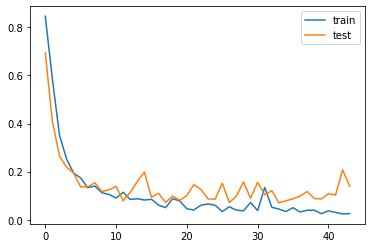

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [0]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [30]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: up


In [31]:
print("Text:",predict(samples))

Text: up
